In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

Скачаем данные и определим Dataset/Dataloader.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [4]:
images[0].shape

torch.Size([3, 32, 32])

Архитектура нашей небольшой сети.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

conv1

In [6]:
(32-5+0)/1+1

28.0

maxpool

In [7]:
(28-2)/2+1

14.0

conv2

In [8]:
(14-5+0)/1+1

10.0

maxpool

In [9]:
(10-2)/2+1

5.0

In [10]:
import torch
a = torch.range(1, 16)

/var/folders/w6/5q18n8_j5pd3kvgw25svnzb80000gp/T/ipykernel_44437/2592517469.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  a = torch.range(1, 16)


In [11]:
a

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])

In [12]:
a = a.view(4, 4)

In [13]:
a

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

In [14]:
a.view(-1, 2)

tensor([[ 1.,  2.],
        [ 3.,  4.],
        [ 5.,  6.],
        [ 7.,  8.],
        [ 9., 10.],
        [11., 12.],
        [13., 14.],
        [15., 16.]])

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
net = net.to(device)

Обучим сеть.

In [18]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.253
[1,  4000] loss: 1.898
[1,  6000] loss: 1.708
[1,  8000] loss: 1.596
[1, 10000] loss: 1.517
[1, 12000] loss: 1.454
[2,  2000] loss: 1.382
[2,  4000] loss: 1.390
[2,  6000] loss: 1.345
[2,  8000] loss: 1.317
[2, 10000] loss: 1.296
[2, 12000] loss: 1.287
Finished Training


In [19]:
torchvision.utils.make_grid(images).shape

torch.Size([3, 36, 138])

Посмотрим на предсказания.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


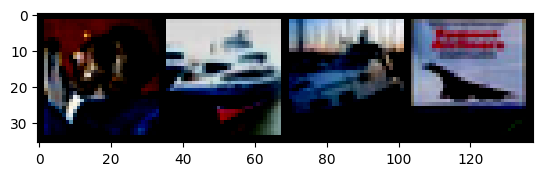

In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
img_grid = img_grid.permute(1, 2, 0)
# print images
plt.imshow(img_grid)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
outputs = net(images)

In [22]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %
